In [53]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sc
import sklearn as sk
import sklearn.covariance as skc
import graph_helpers as gh

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# graphical lasso

On considère $n$ observations $x_{1},x_{2},\ldots ,x_{n}$. On s'interesse à l'estimation d'une matrice de précision $P_0 = C_0^{-1}$. Si on fait l'hypothèse que les $x_i$ sont tirés aléatoirement suivant un va gaussienne $Z$, on espère que le $C_1= P_1^{-1}$ obtenu est une bonne estimation de la matrice de covariance de $Z$. 

Le graphical lasso résout
$$\operatorname {argmin} _{P \geq 0} \operatorname {tr} (C P )-\log \det(P )+\lambda \sum _{j\neq k}|P _{jk}|$$

où $C$ est la covariance des échantillons, et $\lambda$ est le paramètre de pénalisation.

Nous allons tester le graphical lasso sur les différentes formes de graphes synthétisés afin d'évaluer ses performances.

In [387]:
# on définit un graphe par sa matrice de précision
m = 49
a = 0  # corrélation minimum 
name = "ligne"
name = "cyclique"
name = "kvoisin"
name = "grilleCarree" #cyclique ou grilleCarree ou kvoisin
A,Vx,Vy = gh.init_graph(name,m)

U = np.triu((1-a)*np.random.rand(m,m) + a)  # bruit balnc entre a et 1 
U=U+U.T    # Pour que Q soit symétrique
Q = A*U    # matrice de graphe pondéré
assert np.linalg.norm(Q-Q.T)<1e-6, "Q n'est pas symétrique !"

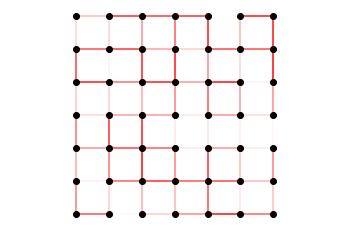

In [325]:
gh.dessin_graphe(Q,Vx,Vy)

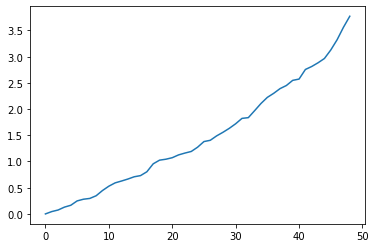

In [388]:
L = np.diag(np.sum(Q, axis = 0)) - Q
plt.plot(np.sort(np.linalg.eigvals(L)))

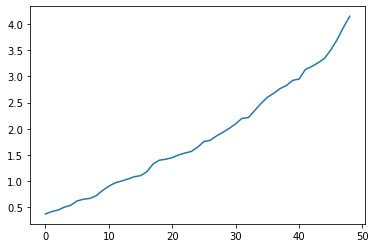

In [389]:
#Pour générer des vecteurs gaussiens de matrice l'inverse de L, L doit être inversible, 
#ce qui n'est pas forcément le cas. On modifie L pour avoir des vp positives
# c est un paramètre qui permet de jouer sur le conditionnement de la matrice de précision

c = 0.1   #10% de la vp maximale est ajoutée à la diagonale

E = np.linalg.eigvals(L)
P0 = L + c*np.max(E)*np.eye(m) 

plt.plot(np.sort(np.linalg.eigvals(P0)))

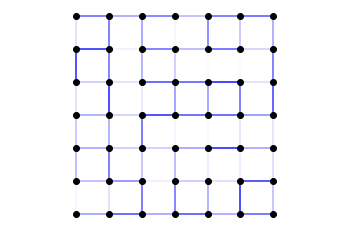

In [390]:
gh.dessin_graphe(P0,Vx,Vy)

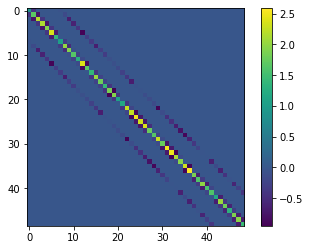

In [391]:
plt.imshow(P0)
plt.colorbar()

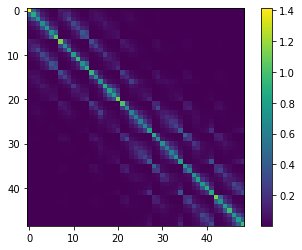

In [392]:
C0 = np.linalg.inv(P0)
plt.imshow(C0)
plt.colorbar()

Pour générer des vecteurs gaussiens de matrice de covariance $C_0$ : 

`w = randn(m,1)` réalisation d'un vecteur gaussien de moyenne nule et de covariance I_m ($E(ww^T) = I_{m\times m}$

Soit $A$ matrice telle que $Z = Aw$. On a Cov($Z$) = $E(ZZ^T) = AA^T = C_0$. On choisit $A = C_0^{\frac{1}{2}}$ car $C_0$ positive.

In [393]:
n = 1000 # nombre d'échantillons
# on génére des va gaussiens de moyenne nulle et de matrice de covariance C0
X = (sc.linalg.sqrtm(C0)@np.random.randn(m,n)).T
#covariance empirique des échantillons
C = X.T@X/n

Dessine un signal généré.

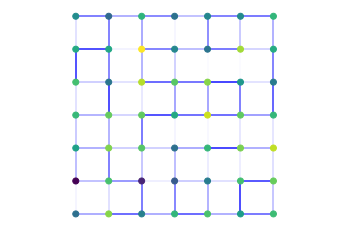

In [394]:
gh.dessin_graphe(P0,Vx,Vy,X[0,:])

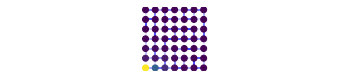

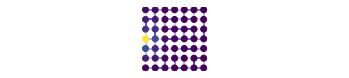

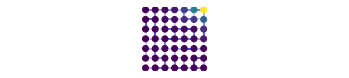

In [395]:
plt.subplot(3,1,1)
gh.dessin_graphe(P0,Vx,Vy,C0[0,:])
plt.subplot(3,1,2)
gh.dessin_graphe(P0,Vx,Vy,C0[m//2-3,:])
plt.subplot(3,1,3)
gh.dessin_graphe(P0,Vx,Vy,C0[-1,:])

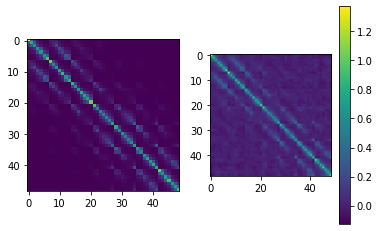

In [396]:
plt.subplot(1,2,1)
plt.imshow(C0)
plt.subplot(1,2,2)
plt.imshow(C)
plt.colorbar()

In [397]:
lamda = 0.05
C1,P1 = skc.graphical_lasso(C,lamda)

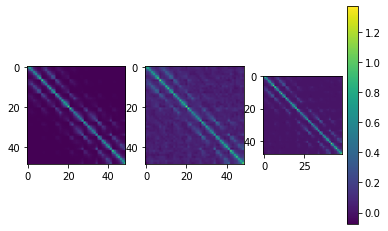

In [398]:
plt.subplot(1,3,1)
plt.imshow(C0)
plt.subplot(1,3,2)
plt.imshow(C)
plt.subplot(1,3,3)
plt.imshow(C1)
plt.colorbar()

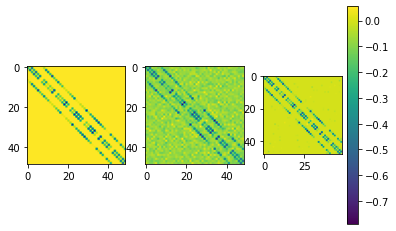

In [399]:
def remove_diag(M):
    return M - np.diag(np.diag(M))
plt.subplot(1,3,1)
plt.imshow(remove_diag(P0))
plt.subplot(1,3,2)
plt.imshow(remove_diag(np.linalg.inv(C)))
plt.subplot(1,3,3)
plt.imshow(remove_diag(P1))
plt.colorbar()

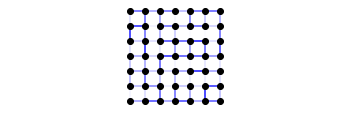

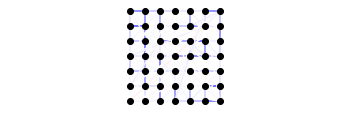

In [400]:
plt.subplot(2,1,1)
gh.dessin_graphe(P0,Vx,Vy)
plt.subplot(2,1,2)
gh.dessin_graphe(P1,Vx,Vy)

# score avec norme L1

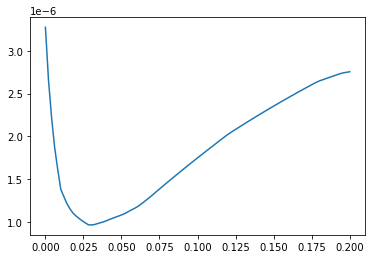

In [401]:
scoreL1 = []
L = list(np.linspace(1e-4,0.2,100))
for lamda in L:
    C1,P1 = skc.graphical_lasso(C,lamda)
    scoreL1.append(np.linalg.norm(P0-P1,1)/n**2)
plt.plot(L,scoreL1)

# norme L1 et barre d'erreur

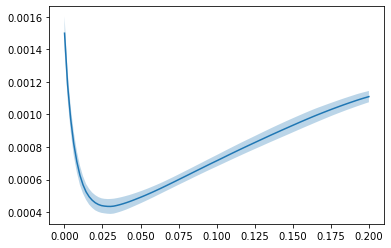

In [402]:
scoreL1 = []
L = list(np.linspace(1e-4,0.2,100))
nrep = 20 
for i in range(nrep):
    X = (sc.linalg.sqrtm(C0)@np.random.randn(m,n)).T
    C = X.T@X/n
    score = []
    for lamda in L:
        C1,P1 = skc.graphical_lasso(C,lamda)
        score.append(np.linalg.norm(P0-P1,1)/m**2)
    scoreL1.append(score)

M = np.mean(scoreL1, axis=0)  
S = np.std(scoreL1, axis=0) 
plt.plot(L,M)
plt.fill_between(L,M-S, M+S ,alpha=0.3)

# score avec "norme 0"

In [403]:
def confusion_result(P0,P1):
    n,p = P0.shape
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(n):
        for j in range(i):
            if P0[i,j]!=0 and P1[i,j]!=0:
                TP +=1
            elif P0[i,j]==0 and P1[i,j]==0:
                FP +=1
            elif P0[i,j]!=0 and P1[i,j]==0:
                TN +=1
            else:
                FN +=1
    return(TP, FP, TN, FN)

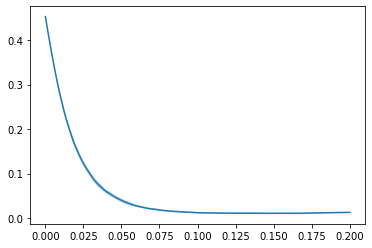

In [404]:
score01 = []
L = list(np.linspace(1e-4,0.2,100))
nrep = 20 
for i in range(nrep):
    X = (sc.linalg.sqrtm(C0)@np.random.randn(m,n)).T
    C = X.T@X/n
    score = []
    for lamda in L:
        C1,P1 = skc.graphical_lasso(C,lamda)
        TP, FP, TN, FN = confusion_result(P0,P1) 
        score.append((TN+FN)/m**2)
    score01.append(score)

M = np.mean(score01, axis=0)  
S = np.std(score01, axis=0) 
plt.plot(L,M)
plt.fill_between(L,M-S, M+S ,alpha=0.3)

Meilleur $\lambda$ pour norme L0 pour $n = 1000$ et $m = 49$: $\lambda = 0.1$

In [405]:
n = 1000 
X = (sc.linalg.sqrtm(C0)@np.random.randn(m,n)).T
C = X.T@X/n

lamda = 0.1
C1,P1 = skc.graphical_lasso(C,lamda)
scoreL1 = np.linalg.norm(P0-P1,1)/m**2
print("scoreL1 = ",scoreL1)
TP, FP, TN, FN = confusion_result(P0,P1) 
scoreL0 = (TN+FN)/m**2
print("scoreL0_GL = ",scoreL0)

scoreL1 =  0.0007782878065374946
scoreL0_GL =  0.015410245730945439


# score ROC-AUC 

# comparaison avec méthode du TP6 : seuillage des éléments de la matrice de corrélation plutot que graphical lasso

In [347]:
correlation_threshold = 0.2
C2 = np.where(C > correlation_threshold, C, 0.0)

In [348]:
scoreL1 = np.linalg.norm(P0-C2,1)/n**2
print("scoreL1 = ",scoreL1)

TP, FP, TN, FN = confusion_result(P0,C2) 
scoreL0 = (TN+FN)/m**2
print("scoreL0 = ",scoreL0)

scoreL1 =  6.737411432566668e-06
scoreL0 =  0.022907122032486463


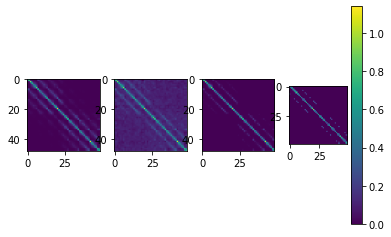

In [349]:
plt.subplot(1,4,1)
plt.imshow(C0)
plt.subplot(1,4,2)
plt.imshow(C)
plt.subplot(1,4,3)
plt.imshow(C1)
plt.subplot(1,4,4)
plt.imshow(C2)
plt.colorbar()

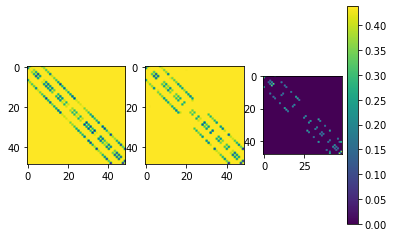

In [350]:
def remove_diag(M):
    return M - np.diag(np.diag(M))
plt.subplot(1,3,1)
plt.imshow(remove_diag(P0))
plt.subplot(1,3,2)
plt.imshow(remove_diag(P1))
plt.subplot(1,3,3)
plt.imshow(remove_diag(C2))
plt.colorbar()

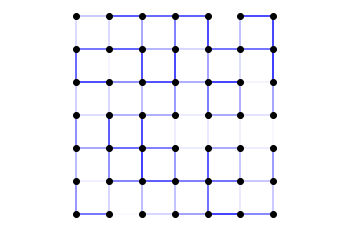

In [351]:
gh.dessin_graphe(P0,Vx,Vy)

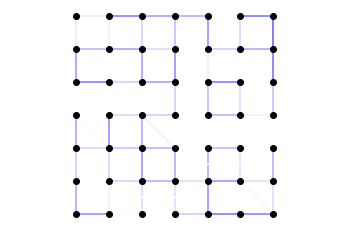

In [352]:
gh.dessin_graphe(P1,Vx,Vy)

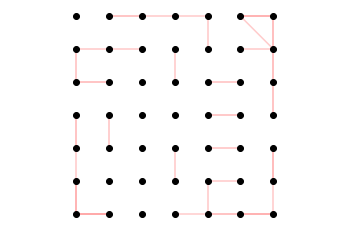

In [353]:
gh.dessin_graphe(C2,Vx,Vy)

# seuillage des éléments de la "presque" matrice de précision 

scoreL1 =  0.0019106928945889395
scoreL0 =  0.05164514785506039


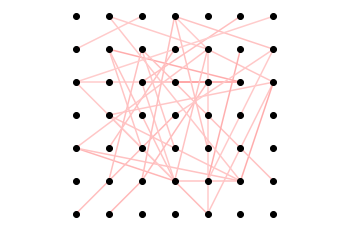

In [362]:
eps =1e-7
P3 = np.linalg.inv(C + eps*np.eye(m))  # car pb de non inversabilité de la matrice de corrélation C

t = 0.2
P3 = np.where(P3 > t, P3, 0.0)

scoreL1 = np.linalg.norm(P0-P3,1)/m**2
print("scoreL1 = ",scoreL1)

TP, FP, TN, FN = confusion_result(P0,P3) 
scoreL0 = (TN+FN)/m**2
print("scoreL0 = ",scoreL0)

gh.dessin_graphe(P3,Vx,Vy)

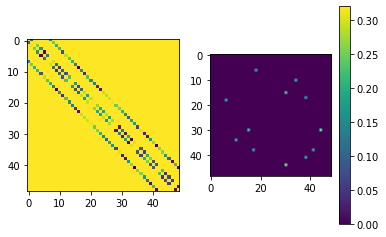

In [355]:
plt.subplot(1,2,1)
plt.imshow(remove_diag(P0))
plt.subplot(1,2,2)
plt.imshow(remove_diag(P3))
plt.colorbar()

# Graphical lasso en fonction de n (nombre d'échantillon)

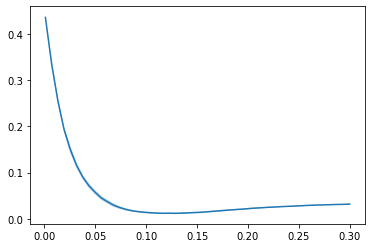

In [361]:
n = 500
score01 = []
L = list(np.linspace(1e-3,0.3,50))
nrep = 20 
for i in range(nrep):
    X = (sc.linalg.sqrtm(C0)@np.random.randn(m,n)).T
    C = X.T@X/n
    score = []
    for lamda in L:
        C1,P1 = skc.graphical_lasso(C,lamda)
        TP, FP, TN, FN = confusion_result(P0,P1) 
        score.append((TN+FN)/m**2)
    score01.append(score)

M = np.mean(score01, axis=0)  
S = np.std(score01, axis=0) 
plt.plot(L,M)
plt.fill_between(L,M-S, M+S ,alpha=0.3)

Meilleur $\lambda$ pour norme L0 pour $n = 500$ et $m = 49$: $\lambda = 0.12$

Meilleur $\lambda$ pour norme L0 pour $n = 1000$ et $m = 49$: $\lambda = 0.1$

Meilleur $\lambda$ pour norme L0 pour $n = 1e4$ et $m = 49$: $\lambda = 0.05$

Meilleur $\lambda$ pour norme L0 pour $n = 1e5$ et $m = 49$: $\lambda = 0.05$

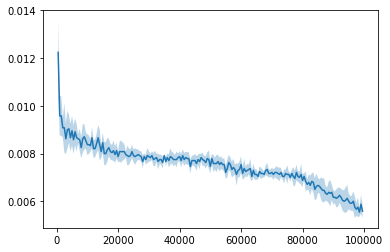

In [383]:
N =  list(range(500,100000,500))
L = list(np.linspace(0.12,0.03,500))
score01 = []
 
for i in range(len(N)):
    nrep = 10
    score = []
    for j in range(nrep):
        X = (sc.linalg.sqrtm(C0)@np.random.randn(m,N[i])).T
        C = X.T@X/N[i]
        C1,P1 = skc.graphical_lasso(C,L[i])
        TP, FP, TN, FN = confusion_result(P0,P1) 
        score.append((TN+FN)/m**2)
    score01.append(score)

M = np.mean(score01, axis=1)  
S = np.std(score01, axis=1) 
plt.plot(N,M)
plt.fill_between(N,M-S, M+S ,alpha=0.3)

# A faire

* tests sur tous les types de graphes

* graphical lasso avec cvxpt, rajouter contraintes Laplacien + article Dong (slides AST6 - 76 et 77)
